In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
# Synthetic data function

def generate_data(start, n_samples, noise_scaling_factor):
    X = np.arange(start, start + n_samples).reshape(-1, 1)
    
    y = 2 * X.flatten() + 1
    
    # Add Gaussian noise to y
    noise = np.random.normal(loc=0, scale=1, size=y.shape)  # Mean = 0, Stddev = 1
    y = y + noise*noise_scaling_factor

    return X, y

In [3]:
# Synthetic Linear Data

X, y = generate_data(1, 100, 10)

Assumption 1 : Linearity

Test 1 : Visualization of rolling mean over data

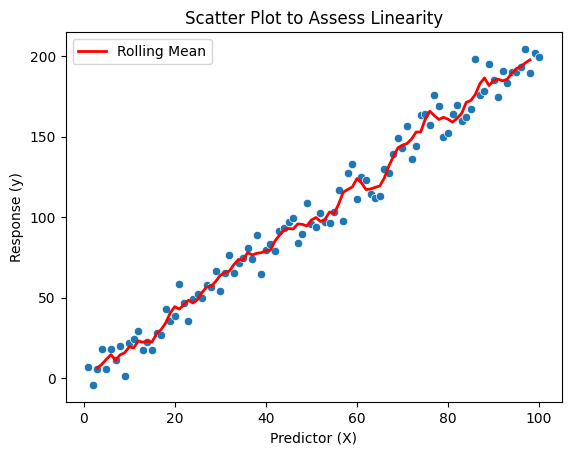

In [4]:
# Testing for linearity via visualization

df = pd.DataFrame({'X': X.flatten(), 'y': y})

# Scatter plot with a rolling mean line to assess linearity
sns.scatterplot(x='X', y='y', data=df)
sns.lineplot(x='X', y='y', data=df.rolling(window=5).mean(), color='red', label='Rolling Mean', linewidth=2)
plt.title('Scatter Plot to Assess Linearity')
plt.xlabel('Predictor (X)')
plt.ylabel('Response (y)')
plt.legend()
plt.show()

Test 2 : Lack-of-fit Test

In [5]:
# Function to calculate sum of squared residuals (SSR)

def calculate_ssr(X, y, coeffs):
    y_pred = X @ coeffs
    residuals = y - y_pred
    ssr = np.sum(residuals ** 2)
    return ssr

In [6]:
# Lack-of-Fit test implementation

def lack_of_fit_test(X, y):
    # Fit a simple linear model
    X_linear = np.hstack([np.ones_like(X), X])  # Adding intercept term
    coeffs_linear = np.linalg.lstsq(X_linear, y, rcond=None)[0]
    ssr_linear = calculate_ssr(X_linear, y, coeffs_linear)
    df_linear = len(y) - X_linear.shape[1]  # Degrees of freedom for the linear model

    # Fit a more complex model (quadratic)
    X_complex = np.hstack([np.ones_like(X), X, X**2])  # Adding a quadratic term
    coeffs_complex = np.linalg.lstsq(X_complex, y, rcond=None)[0]
    ssr_complex = calculate_ssr(X_complex, y, coeffs_complex)
    df_complex = len(y) - X_complex.shape[1]  # Degrees of freedom for the complex model

    # Calculate F-statistic
    num = (ssr_linear - ssr_complex) / (df_linear - df_complex)
    denom = ssr_complex / df_complex
    F = num / denom

    # Calculate the p-value
    p_value = 1 - f.cdf(F, df_linear - df_complex, df_complex)

    return F, p_value

In [7]:
def assess_linearity(F_statistic, p_value):
    print(f"F-statistic: {F_statistic}")
    print(f"P-value: {p_value}")
    
    # Interpretation
    if p_value < 0.05:
        print("There is evidence of non-linearity (reject the null hypothesis).")
    else:
        print("No evidence of non-linearity (fail to reject the null hypothesis).")

In [8]:
# Perform the Lack-of-Fit test

F_statistic, p_value = lack_of_fit_test(X, y)

In [9]:
#Assessing linearity

assess_linearity(F_statistic, p_value)

F-statistic: 0.23476776928130172
P-value: 0.6291032205552098
No evidence of non-linearity (fail to reject the null hypothesis).


In [10]:
# Synthetic data function for nonlinear data

def generate_nonlinear_data(start, n_samples, noise_scaling_factor):
    X = np.arange(start, start + n_samples).reshape(-1, 1)
    
    # Introduce a quadratic relationship
    y = 0.5 * X.flatten()**2 + 2 * X.flatten() + 1
    
    # Add Gaussian noise to y
    noise = np.random.normal(loc=0, scale=5, size=y.shape)  # Mean = 0, Stddev = 5
    y = y + noise*noise_scaling_factor

    return X, y

In [11]:
# Generate the nonlinear data

X, y = generate_nonlinear_data(1, 100, 10)

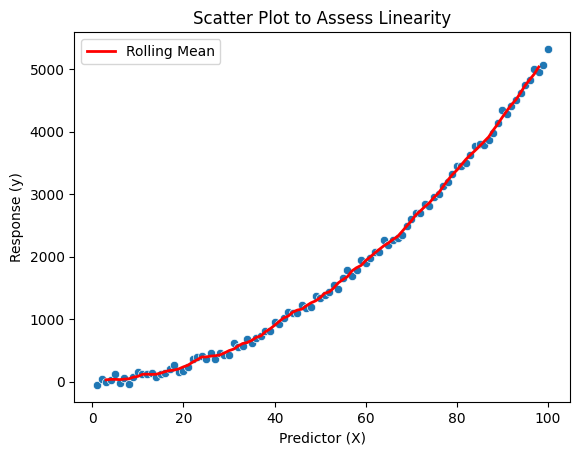

In [12]:
# Testing for linearity via visualization

df = pd.DataFrame({'X': X.flatten(), 'y': y})

# Scatter plot with a rolling mean line to assess linearity
sns.scatterplot(x='X', y='y', data=df)
sns.lineplot(x='X', y='y', data=df.rolling(window=5).mean(), color='red', label='Rolling Mean', linewidth=2)
plt.title('Scatter Plot to Assess Linearity')
plt.xlabel('Predictor (X)')
plt.ylabel('Response (y)')
plt.legend()
plt.show()

In [13]:
# Perform the Lack-of-Fit test

F_statistic, p_value = lack_of_fit_test(X, y)

In [14]:
#Assessing linearity

assess_linearity(F_statistic, p_value)

F-statistic: 4745.3943286882
P-value: 1.1102230246251565e-16
There is evidence of non-linearity (reject the null hypothesis).


Assumption 2 : Independence of Residual Correlation (No Autocorrelation)

Test : Durbin Watson

In [15]:
# Synthetic Linear Data

X, y = generate_data(1, 100, 10)

In [16]:
# Function to calculate the Durbin-Watson statistic

def durbin_watson_test(residuals):
    # Compute the differences between successive residuals
    diff_residuals = np.diff(residuals)
    
    # Numerator: Sum of squared differences between residuals
    numerator = np.sum(diff_residuals**2)
    
    # Denominator: Sum of squared residuals
    denominator = np.sum(residuals**2)
    
    # Durbin-Watson statistic
    d = numerator / denominator
    return d


In [17]:
def durbin_watson_interpretation(d_statistic):
    if 1.5 <= d_statistic <= 2.5:
        print("No autocorrelation detected")
    else:
        print("Autocorrelation detected")

In [18]:
# Fitting the linear model

model = sm.OLS(y, X).fit()
residuals = model.resid

In [19]:
# Calculate the Durbin-Watson statistic

d_statistic = durbin_watson_test(residuals)
print(f'Durbin-Watson Statistic: {d_statistic}')

Durbin-Watson Statistic: 1.7685856278216403


In [20]:
# Durbin Watson Interpretation

durbin_watson_interpretation(d_statistic)

No autocorrelation detected


In [21]:
# Function of Generating autocorrelated data

def generate_autocorrelated_data(n_samples, phi=0.9):
    """
    Generate synthetic data with autocorrelated errors.

    Parameters:
    - n_samples: Number of samples to generate.
    - phi: The autocorrelation coefficient (between 0 and 1). 
            Higher values lead to stronger correlation.

    Returns:
    - X: Independent variable (array).
    - y: Dependent variable (array) with autocorrelated errors.
    """
    # Generate independent variable X
    X = np.arange(n_samples).reshape(-1, 1)
    
    # Initialize the dependent variable y
    y = np.zeros(n_samples)

    # Generate errors with autocorrelation
    errors = np.random.normal(0, 1, n_samples)
    for i in range(1, n_samples):
        errors[i] += phi * errors[i - 1]  # Introduce autocorrelation

    # Create the dependent variable with a linear relationship
    y = 2 * X.flatten() + 5 + errors  # y = 2*X + 5 + autocorrelated error

    return X, y

In [22]:
# Generating autocorrelated data

X, y = generate_autocorrelated_data(100)

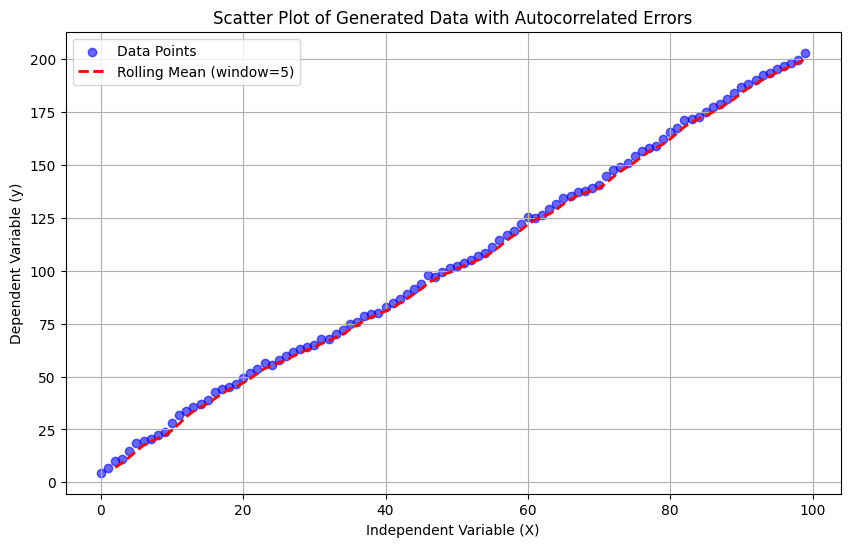

In [23]:
# Visualizing autocorrelated data


# Calculate rolling mean
rolling_mean = pd.Series(y).rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Data Points')

# Plot the rolling mean
plt.plot(X, rolling_mean, color='red', linestyle='--', linewidth=2, label='Rolling Mean (window=5)')

plt.title('Scatter Plot of Generated Data with Autocorrelated Errors')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (y)')
plt.legend()
plt.grid()
plt.show()

In [24]:
# Fitting the linear model

model = sm.OLS(y, X).fit()
residuals = model.resid

In [25]:
# Calculate the Durbin-Watson statistic

d_statistic = durbin_watson_test(residuals)
print(f'Durbin-Watson Statistic: {d_statistic}')

Durbin-Watson Statistic: 0.06571153745638471


In [26]:
# Durbin Watson Interpretation

durbin_watson_interpretation(d_statistic)

Autocorrelation detected


Assumption 3 : Homoscadesticity

In [27]:
# Synthetic Linear Data

X, y = generate_data(1, 100, 10)

In [28]:
# Function to perform White's Test for heteroscedasticity

def white_test(X, y):
    # Step 1: Fit the original regression model
    X_with_const = sm.add_constant(X)  # Add a constant to include the intercept
    model = sm.OLS(y, X_with_const).fit()
    residuals = model.resid
    
    # Step 2: Create a DataFrame with independent variables and residuals
    df = pd.DataFrame(X_with_const, columns=['const'] + [f'X{i}' for i in range(1, X_with_const.shape[1])])
    df['residuals_sq'] = residuals**2

    # Add squared terms of independent variables
    for i in range(1, X_with_const.shape[1]):
        df[f'X{i}_sq'] = df[f'X{i}']**2

    # Add cross-product terms
    if X_with_const.shape[1] > 2:  # Only if there are multiple predictors
        for i in range(1, X_with_const.shape[1]):
            for j in range(i+1, X_with_const.shape[1]):
                df[f'X{i}_X{j}'] = df[f'X{i}'] * df[f'X{j}']

    # Step 3: Fit an auxiliary regression of squared residuals on the independent variables, their squares, and cross-products
    independent_vars = df.drop(columns=['residuals_sq'])
    model_auxiliary = sm.OLS(df['residuals_sq'], independent_vars).fit()

    # Step 4: Calculate the White test statistic
    n = len(y)
    R_squared = model_auxiliary.rsquared
    white_statistic = n * R_squared

    # Step 5: Calculate the p-value using the chi-squared distribution
    df_white = independent_vars.shape[1] - 1  # Degrees of freedom = number of independent variables in auxiliary regression
    p_value = 1 - stats.chi2.cdf(white_statistic, df_white)

    return white_statistic, p_value

In [29]:
def asses_homoscedasticity(p_value):
    # Interpretation
    if p_value < 0.05:
        print("Heteroscedasticity detected (p < 0.05)")
    else:
        print("No heteroscedasticity detected (p >= 0.05)")

In [30]:
# Perform White's Test

white_statistic, p_value = white_test(X, y)
print(f"White's test statistic: {white_statistic}")
print(f"p-value: {p_value}")

White's test statistic: 0.28144296217098574
p-value: 0.8687312360867182


In [31]:
# Assess Homoscedasticity

asses_homoscedasticity(p_value)

No heteroscedasticity detected (p >= 0.05)


In [32]:
# Function to generate data with heteroscedasticity

def generate_heteroscedastic_data(n_samples=100, start=0, end=10, noise_scale_factor=0.5):
    """
    Generates synthetic data with heteroscedasticity.
    
    Parameters:
    - n_samples (int): Number of samples.
    - start (float): Start value of X.
    - end (float): End value of X.
    - noise_scale_factor (float): Scale factor for noise, larger values create more variance.
    
    Returns:
    - X (numpy array): Independent variable.
    - y (numpy array): Dependent variable with heteroscedasticity.
    """
    np.random.seed(42)  # For reproducibility

    # Generate X values evenly spaced
    X = np.linspace(start, end, n_samples)
    
    # Generate heteroscedastic noise (variance increases with X)
    noise = np.random.normal(0, noise_scale_factor * X, size=n_samples)
    
    # Generate y values (linear trend + heteroscedastic noise)
    y = 2 * X + 5 + noise
    
    return X, y

In [33]:
# Generating heteroscedastic data

X, y = generate_heteroscedastic_data()

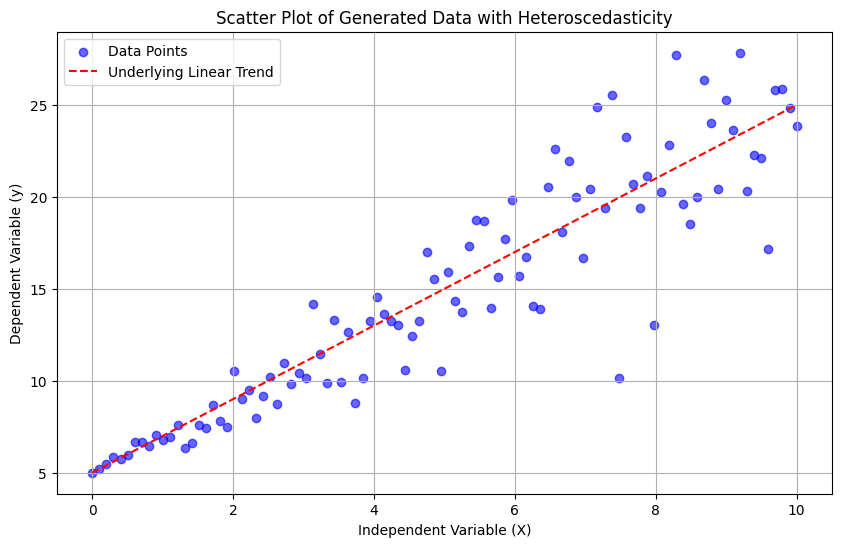

In [34]:
# Plot the generated data to visualize heteroscedasticity

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Data Points')
plt.plot(X, 2 * X + 5, color='red', linestyle='--', label='Underlying Linear Trend')
plt.title('Scatter Plot of Generated Data with Heteroscedasticity')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (y)')
plt.legend()
plt.grid()
plt.show()

In [35]:
# Perform White's Test

white_statistic, p_value = white_test(X, y)
print(f"White's test statistic: {white_statistic}")
print(f"p-value: {p_value}")

White's test statistic: 12.23540740663619
p-value: 0.0022035100708204247


In [36]:
# Assess Homoscedasticity

asses_homoscedasticity(p_value)

Heteroscedasticity detected (p < 0.05)


Assumption 4 : Normality of Error

In [37]:
def assess_normality(statistic, p_value):
    # Output the results
    print(f"Shapiro-Wilk Test Statistic: {statistic}")
    print(f"p-value: {p_value}")
    
    # Interpretation of the p-value
    alpha = 0.05
    if p_value > alpha:
        print("The residuals are normally distributed (fail to reject H0).")
    else:
        print("The residuals are not normally distributed (reject H0).")

In [38]:
# Synthetic Linear Data

X, y = generate_data(1, 100, 10)

In [39]:
# Fit the model

model = sm.OLS(y, X).fit()

In [40]:
# Calculate residuals

residuals = model.resid

In [41]:
# Perform the Shapiro-Wilk test for normality of residuals

statistic, p_value = shapiro(residuals)

In [42]:
assess_normality(statistic, p_value)

Shapiro-Wilk Test Statistic: 0.9740360751234212
p-value: 0.045364062185239105
The residuals are not normally distributed (reject H0).


Assumption 5 : No Multicolinearity

In [43]:
# Generate linear data for multiple regression

def generate_multiple_regression_data(n_samples, n_features, coefficients, noise_mean=0, noise_std=1):
    """
    Generates synthetic data for a multiple regression model.
    
    Parameters:
    n_samples (int): The number of data points (samples).
    n_features (int): The number of predictors (features).
    coefficients (list): A list of coefficients for each predictor.
    noise_mean (float): The mean of the Gaussian noise.
    noise_std (float): The standard deviation of the Gaussian noise.
    
    Returns:
    X (ndarray): The generated feature matrix of shape (n_samples, n_features).
    y (ndarray): The generated target values of shape (n_samples,).
    """
    # Ensure the number of coefficients matches the number of features
    assert len(coefficients) == n_features, "Number of coefficients must match number of features"
    
    # Generate random feature matrix X
    X = np.random.rand(n_samples, n_features)
    
    # Calculate the target variable y using the linear combination of features and coefficients
    y = X @ np.array(coefficients) + np.random.normal(loc=noise_mean, scale=noise_std, size=n_samples)
    
    return X, y

In [44]:
# Generating Multiple Regression Data

n_samples = 100
n_features = 3
coefficients = [1.5, -2.0, 3.0]  # Coefficients for each predictor

X, y = generate_multiple_regression_data(n_samples, n_features, coefficients)

In [45]:
# Function for calculating VIF

def calculate_vif(X):
    """
    Calculates the Variance Inflation Factor (VIF) for each predictor in the dataset.
    
    Parameters:
    X (DataFrame): A DataFrame containing the predictors.
    
    Returns:
    DataFrame: A DataFrame with the predictors and their corresponding VIF values.
    """
    X = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(n_features)])
    # Add a constant to the model (intercept)
    X = add_constant(X)
    
    # Create a DataFrame to store VIF values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculate VIF for each predictor
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

In [46]:
def assess_multicollinearity(vif_data):
    """
    Assess multicollinearity using Variance Inflation Factor (VIF).
    
    Parameters:
    X : pd.DataFrame
        The independent variables (features).
    
    Returns:
    pd.DataFrame
        A DataFrame containing features and their corresponding VIF values with interpretations.
    """
    
    # Interpret the VIF values
    interpretations = []
    for v in vif_data['VIF']:
        if v < 5:
            interpretations.append("Low multicollinearity")
        elif 5 <= v < 10:
            interpretations.append("Moderate multicollinearity; consider further investigation")
        else:
            interpretations.append("High multicollinearity; consider removing this feature")
    
    vif_data['Interpretation'] = interpretations
    return vif_data

In [47]:
# Calculate VIF values

vif_data = calculate_vif(X)
print(vif_data)

     Feature       VIF
0      const  8.671348
1  Feature_1  1.029467
2  Feature_2  1.012547
3  Feature_3  1.026816


In [48]:
# Assess Multicolinearity

assess_multicollinearity(vif_data)

,Feature,VIF,Interpretation
0,const,8.671348,Moderate multicollinearity; consider further i...
1,Feature_1,1.029467,Low multicollinearity
2,Feature_2,1.012547,Low multicollinearity
3,Feature_3,1.026816,Low multicollinearity
